# Tarea 2 - Regresion Polinomial & Feature engineering

### Parte 1 - Modelo exponencial de covid-19 usando feature-eng

Usando el ejemplo de covid-19 en el notebook de feature-eng (https://colab.research.google.com/drive/1sJV2HG7tQgCGKES3-dIclzHQJ9qAWB3b?usp=sharing) crear un modelo de covid-19 para Guatemala.

* Convertir la fecha a un entero "número de día", por ejemplo si se usan datos desde el 22 de abril, este es el día 0, el 23 es el día 1.
* Aplicar regresión lineal sobre la variable "Confirmed" transformada.
* Una vez entrenado el modelo usarlo para aproximar la cantidad de casos confirmados para el 30 de mayo. Se debe reportar la cantidad de casos, no la cantidad transformada obtenida.

In [34]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
#from google.colab import drive 
from scipy.stats import norm
from datetime import datetime as dt
#from pandas_datareader import data
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
%reload_ext tensorboard

### Parte 2 - Modelo polinomial de calidad de vinos

Es permitido utilizar [sklearn.preprocessing.polynomialfeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)


### Instrucciones

1. Seleccionar y transformar(generando las combinaciones polinomiales para un polinomio de grado dos o tres a elección) las features que considere que son las mejores para predecir la calidad del vino, utilizar como minimo 2 features. Para seleccionar las features, hacer un analisis exploratorio por ejemplo(pero no limitado a ):  graficando y viendo la forma en que se comportan los datos.

 Por ejemplo, se tienen las features "a" y "b" y seleccionamos polinomio de grado 2, hacemos feature engineering para obtener :
 
 $[a,b,a^{2},b^{2},ab]$
 
 No olvidar el "bias" (parámetro multiplicado por 1) ,con lo cual el dataset puede quedar con las columnas:
 
 $[1,a,b,a^{2},b^{2},ab]$
2. Una vez transformada la data aplicar regresion lineal con las features polinomiales usando Tensorflow.

Requisitos adicionales:
* Se debe agregar al notebook un screenshot del grafo de tensorboard, simplificando(usando  names , y name_scope como visto en clase).

* Se debe generar un directorio de logs de tensorboard para cada corrida/experimento , con cada directorio identificando facilmente la configuración del experimento como visto en clase, por ejemplo para un experimento con learning rate = 0.1 , y polinomio grado 2  crear un directorio: lr=0.1_polinomio_grado=2. (Agregar al notebook un screenshot de estas gráficas)

* Concluir en markdown cual es el mejor modelo para este caso basado en la comparativa entre curvas de costo/error en tensorboard.

In [35]:
data = pd.read_csv('winequality-red.csv')

In [82]:
#data.corr()

xdatos = data[['volatile acidity', 'alcohol']]
ydatos = data[['quality']]

xdatos.head()


,volatile acidity,alcohol
0,0.70,9.4
1,0.88,9.8
2,0.76,9.8
3,0.28,9.8
4,0.70,9.4


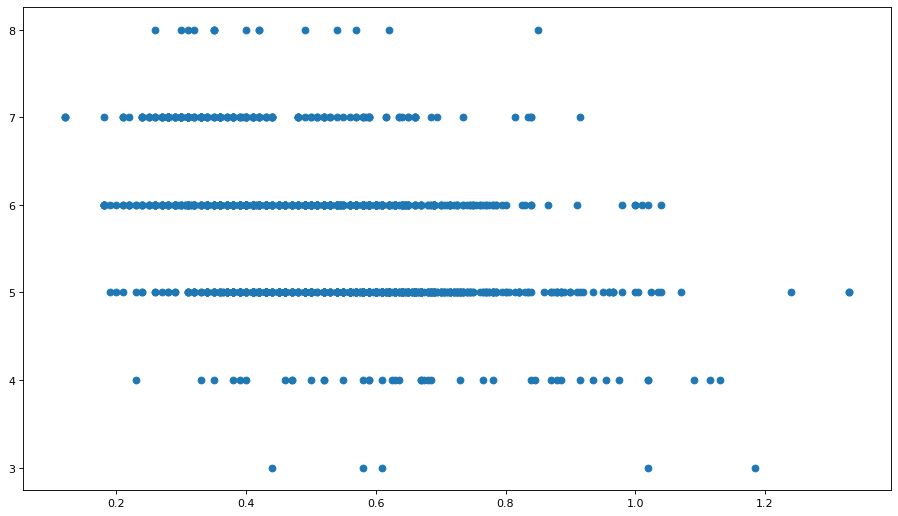

In [73]:
plt.scatter(xdatos['volatile acidity'], ydatos)

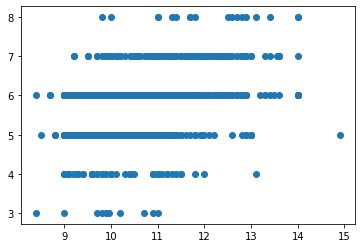

In [83]:
plt.scatter(xdatos['alcohol'], ydatos)

In [75]:
xent = xdatos.copy()
yent = ydatos.copy()
xent.columns=['a', 'b']
xent['ab'] = xent['a']*xent['b']
xent['a^2'] = xent['a']*xent['a']
xent['b^2'] = xent['b']*xent['b']
xent.insert(0,'',1)

pol = xent.shape[1]

,,a,b,ab,a^2,b^2
0,1,0.70,9.4,6.580,0.4900,88.36
1,1,0.88,9.8,8.624,0.7744,96.04
2,1,0.76,9.8,7.448,0.5776,96.04
3,1,0.28,9.8,2.744,0.0784,96.04
4,1,0.70,9.4,6.580,0.4900,88.36


In [77]:
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    xplace = tf.placeholder(tf.float32, shape = (None, pol), name = "X")
    yplace = tf.placeholder(tf.float32, shape = (None, 1), name = "Y")

    lr = tf.placeholder(tf.float32, name = "lr")

    W = tf.Variable(tf.zeros([pol, 1], tf.float32), name = "W")

    with tf.name_scope("Hipotesis"):
        Yhat = tf.matmul(xplace, W, name = "Diferencia_Y") 
        
    with tf.name_scope("Costo"):
        cost = tf.divide( tf.reduce_mean(tf.pow(Yhat-yplace, 2)), 2., name="fCosto")

    with tf.name_scope("Gradient_Descent"):
        optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost)
        costSummary = tf.summary.scalar(name='funcion de costo', tensor = cost)
    init = tf.global_variables_initializer()


In [80]:
logs_dir = r"C:\Users\Sebastián\Desktop\regresion_polinomial\logs"

def entrenamiento(x, y, training_epochs, learning_rate,n){
    with tf.Session(graph = g) as sess: 
        writer = tf.summary.FileWriter(logs_dir, sess.graph)        
        sess.run(init) 

        for epoch in range(training_epochs): 
            _, summary = sess.run([optimizer, costSummary], feed_dict = {xplace: xent, yplace: yent, lr : learning_rate})
            writer.add_summary(summary, epoch+1)
            if (epoch + 1) % n == 0: 
                c, weights = sess.run([cost, W], feed_dict = {xplace : x, yplace : y}) 
                print("E:", (epoch + 1), "\tGrado_de_Polinomio=", pol,"\tValoro_Costo=", c, "\tMuestra_W=", weights[:3,0]) 
        writer.close()
        
        finalCost = sess.run(cost, feed_dict ={xplace: xent, yplace: yent}) 
        weights = sess.run(W)        
    return (weights)
    
    
}

In [81]:
weights = entrenarModeloLineal(trainX, trainY, 300, 0.0001, 30)

E: 30 	Grado_de_Polinomio= 6 	Valor_del_Costo= 0.57396644 	Muestra_para_W= [0.00094795 0.00045542 0.00738845]
E: 60 	Grado_de_Polinomio= 6 	Valor_del_Costo= 0.57085836 	Muestra_para_W= [0.00145953 0.00068624 0.01014984]
E: 90 	Grado_de_Polinomio= 6 	Valor_del_Costo= 0.56779873 	Muestra_para_W= [0.00196827 0.00091401 0.01289599]
E: 120 	Grado_de_Polinomio= 6 	Valor_del_Costo= 0.56478673 	Muestra_para_W= [0.0024742  0.00113877 0.01562705]
E: 150 	Grado_de_Polinomio= 6 	Valor_del_Costo= 0.5618211 	Muestra_para_W= [0.00297736 0.00136056 0.01834316]
E: 180 	Grado_de_Polinomio= 6 	Valor_del_Costo= 0.5589008 	Muestra_para_W= [0.00347775 0.00157942 0.02104448]
E: 210 	Grado_de_Polinomio= 6 	Valor_del_Costo= 0.55602473 	Muestra_para_W= [0.00397542 0.0017954  0.02373113]
E: 240 	Grado_de_Polinomio= 6 	Valor_del_Costo= 0.55319184 	Muestra_para_W= [0.00447039 0.00200854 0.02640326]
E: 270 	Grado_de_Polinomio= 6 	Valor_del_Costo= 0.5504011 	Muestra_para_W= [0.00496269 0.00221887 0.02906103]
E: 300 

In [55]:
trainX3 = trainX.copy()
# Agregamos las características a X
trainX3['ab^2'] = trainX['a'] * trainX['b^2']
trainX3['ba^2'] = trainX['b'] * trainX['a^2']
trainX3['a^3'] = trainX['a'] ** 3
trainX3['b^3'] = trainX['b'] ** 3

# Obtenemos el número de parámetros a estimar: K
K = trainX3.shape[1]

trainX3.head()

,,a,b,ab,a^2,b^2,ab^2,ba^2,a^3,b^3
0,1,0.70,9.4,6.580,0.4900,88.36,61.8520,4.60600,0.343000,830.584
1,1,0.88,9.8,8.624,0.7744,96.04,84.5152,7.58912,0.681472,941.192
2,1,0.76,9.8,7.448,0.5776,96.04,72.9904,5.66048,0.438976,941.192
3,1,0.28,9.8,2.744,0.0784,96.04,26.8912,0.76832,0.021952,941.192
4,1,0.70,9.4,6.580,0.4900,88.36,61.8520,4.60600,0.343000,830.584


In [84]:
%tensorboard --logdir="C:\Users\Sebastián\Desktop\regresion_polinomial\logs"

Reusing TensorBoard on port 6006 (pid 1856), started 0:18:11 ago. (Use '!kill 1856' to kill it.)

In [57]:
%tensorboard --logdir="C:\Users\Sebastián\Desktop\regresion_polinomial\logs"

Reusing TensorBoard on port 6006 (pid 1856), started 0:05:29 ago. (Use '!kill 1856' to kill it.)

# Conclusión

A pesar de que se eligiò una variable como alcohol como la más representativa para trabajar el modelo, es perfectamente posible trabajarlo con más de 1 variable a la vez y ajustar un polinoomio con un grado K cualquiera que nos permita hacer la relaciòn entre ellas. 

Podemos trabajar con comparativas de un polinomio de grado perfecto en comparación de uno de mayor grado para validar que el de grado perfecto no siempre es la mejor alternativa. 

Se cumple la hipotesis planteada y se verifica la relación con la variable elegida.

### Red Wine Quality Data

Se aplicará regresión para crear un modelo de la calidad de vino en función de características del mismo, siendo 1 el peor vino y 10 el mejor.

Variables de entrada:
1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol 

Varaible a predecir: 
12. quality (puntuacion  entre 0 y 10) 



In [6]:
data.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


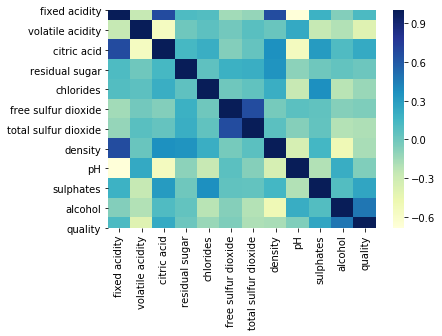

In [30]:
Mat_corr = data.corr()
sns.heatmap(Mat_corr,cmap="YlGnBu")

In [31]:
x = data[['quality']]
y = data[['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']]

xtrain,xtest,ytrain,ytest = train_test_split(x, y, test_size=0.1)

modelo = linear_model.LinearRegression()
modelo = modelo.fit(ytrain, xtrain)
pred_data = modelo.predict(ytest)
pred_data = np.round_(pred_data)

print(pred_data)

[[5.]
 [5.]
 [6.]
 [6.]
 [5.]
 [5.]
 [6.]
 [5.]
 [6.]
 [6.]
 [5.]
 [6.]
 [5.]
 [5.]
 [6.]
 [5.]
 [5.]
 [5.]
 [5.]
 [6.]
 [5.]
 [7.]
 [5.]
 [5.]
 [5.]
 [5.]
 [6.]
 [5.]
 [6.]
 [5.]
 [6.]
 [5.]
 [6.]
 [5.]
 [6.]
 [6.]
 [6.]
 [5.]
 [6.]
 [5.]
 [5.]
 [5.]
 [6.]
 [5.]
 [5.]
 [7.]
 [5.]
 [6.]
 [6.]
 [5.]
 [6.]
 [6.]
 [5.]
 [5.]
 [6.]
 [6.]
 [5.]
 [5.]
 [6.]
 [5.]
 [6.]
 [6.]
 [5.]
 [6.]
 [6.]
 [6.]
 [5.]
 [5.]
 [6.]
 [6.]
 [5.]
 [7.]
 [6.]
 [5.]
 [6.]
 [6.]
 [5.]
 [5.]
 [5.]
 [5.]
 [5.]
 [6.]
 [6.]
 [5.]
 [6.]
 [5.]
 [5.]
 [5.]
 [6.]
 [6.]
 [5.]
 [5.]
 [6.]
 [6.]
 [5.]
 [5.]
 [5.]
 [5.]
 [5.]
 [6.]
 [5.]
 [5.]
 [6.]
 [6.]
 [5.]
 [6.]
 [6.]
 [5.]
 [5.]
 [6.]
 [5.]
 [5.]
 [6.]
 [6.]
 [5.]
 [5.]
 [6.]
 [6.]
 [7.]
 [6.]
 [6.]
 [7.]
 [6.]
 [5.]
 [6.]
 [5.]
 [6.]
 [6.]
 [6.]
 [6.]
 [6.]
 [7.]
 [6.]
 [6.]
 [6.]
 [6.]
 [6.]
 [6.]
 [5.]
 [7.]
 [6.]
 [7.]
 [7.]
 [6.]
 [6.]
 [5.]
 [6.]
 [5.]
 [5.]
 [6.]
 [6.]
 [6.]
 [5.]
 [6.]
 [5.]
 [6.]
 [5.]
 [5.]
 [5.]
 [5.]]


In [28]:
print(mean_squared_error(xtest,pred_data))

0.45625


# Conclusión

No es necesario que se utilicen todas las variables para realizar el análisis. Podrìa utilziar Fixed acidity y la cantidad de alcohol podrían ser 2 parámetros a considerar para tener una mejor predicción en lugar de todas juntas. 